# Octave DSP Notebook

This notebook represents the analysis and initial compositional exploration done in order to create a first composition in the style of (or inspired by) the School of Spectralism.

## Sections

The content of this notebook is divided into three sections:

* [Setup](/notebooks/audio-dsp-and-spectralism.ipynb#Setup)
* [Preparation for Composition](/notebooks/audio-dsp-and-spectralism.ipynb#Preparation-for-Composition)
* [Spectralism: Composing in the Spirit of Gérard Grisey](/notebooks/audio-dsp-and-spectralism.ipynb#Spectralism:-Composing-in-the-Spirit-of-G%C3%A9rard-Grisey)
* [Appendices](/notebooks/audio-dsp-and-spectralism.ipynb#Appendices)

## Setup

In [1]:
% Load the signal processing package
pkg load signal;
pkg load image;

% Set up plotting
graphics_toolkit('gnuplot');

% Pull in custom functions
source('packages/custom-util/fs.m');
source('packages/custom-util/strings.m');
source('packages/custom-dsp/freq-analysis.m');
source('packages/custom-dsp/time-varying-analysis.m');
source('packages/custom-dsp/rhythmic-analysis.m');
source('packages/custom-dsp/spectral-io.m');
source('packages/custom-dsp/rhythmic-io.m');

printf('\nOctave DSP ready ...\n');

File system functions loaded!
String functions loaded!
Static frequency analysis functions loaded!
Time-varying analysis functions loaded!
Rhythmic analysis functions loaded!
Spectral I/O functions loaded!

Octave DSP ready ...


Note: the above `source` calls include functions specifically written for this exploration and are not part of any official or community Octave package. Their sources are displayed at the bottom of this document.

### Baseline: Sine Tone

Before diving into the spectrum analysis of actual instruments, let's establish a baseline using a sine tone at 440 Hz:

In [2]:
% Generate a pure 440 Hz sine wave
fs = 44100;
duration = 1.0;
t = (0:1/fs:duration-1/fs)';
f0 = 440.0;  % A4

y = sin(2*pi*f0*t);

printf('Generated 440 Hz sine wave: %d samples\n', length(sine));

error: 'sine' undefined near line 1, column 59


In [3]:
% Analyze harmonics
window_size = 8192;
[freqs, amps, meta] = analyze_static_spectrum(y, fs, window_size);
print_harmonics(freqs, amps);

Frequency    Closest    MIDI       Partial       Amplitude    Velocity   Dynamic 
(Hz)         Note       Note       Ratio         (dBFS)       (MIDI)             
-------------------------------------------------------------------------------------
441.4        A4         69         1.00          -6.4         117        ff      


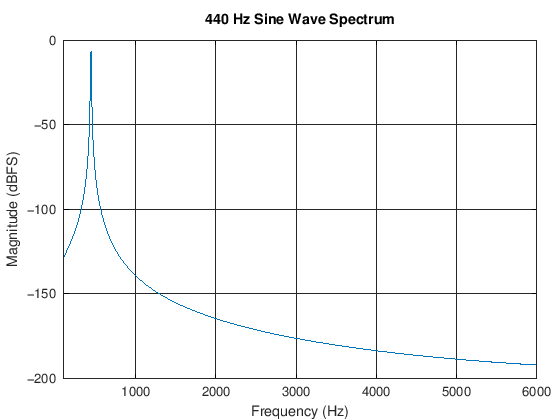

In [4]:
plot_spectrum(y, fs, 8192, '440 Hz Sine Wave Spectrum');

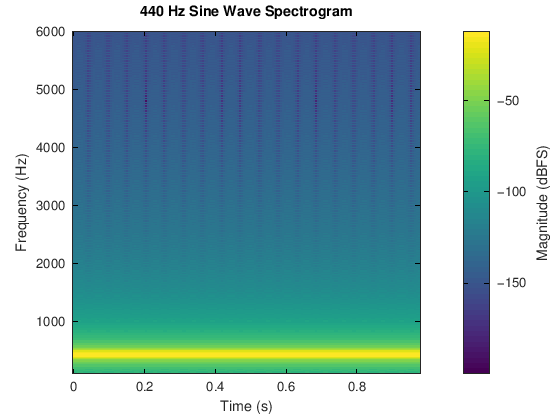

In [5]:
plot_spectrogram(y, fs, '440 Hz Sine Wave Spectrogram');

## Preparation for Composition

### Physical Instrument Samples

The `.wav` files used below were generated using Spitfire Audio's library "Studio Woodwinds Professional."

#### Clarinet

The following clarinet recording is of E4 with vibrato:

In [6]:
inst_lower = 'clarinet';
inst_title = titlecase(inst_lower);
input_file = strcat('audio/', inst_lower, '.wav');

[y, fs] = audioread(input_file);

% We only need one channel from a stereo wav file
if size(y, 2) > 1
    y = y(:, 1);
end

printf('Loaded: %d samples at %d Hz\n', length(y), fs);

Loaded: 384000 samples at 48000 Hz


In [7]:
% High-pass filter at 80 Hz to remove DC offset and rumble
[b, a] = butter(4, 80/(fs/2), 'high');
y = filter(b, a, y);

% Analyze
[freqs, amps, meta] = analyze_static_spectrum(y, fs, window_size);
print_harmonics(freqs, amps);

Frequency    Closest    MIDI       Partial       Amplitude    Velocity   Dynamic 
(Hz)         Note       Note       Ratio         (dBFS)       (MIDI)             
-------------------------------------------------------------------------------------
328.1        E4         64         1.00          -27.6        83         mf      
656.2        E5         76         2.00          -40.2        59         p       
990.2        B5         83         3.02          -23.7        90         mf      
1318.4       E6         88         4.02          -27.8        83         mf      
1529.3       G6         91         4.66          -64.2        1          pppp    
1646.5       G#6        92         5.02          -25.8        86         mf      
1734.4       A6         93         5.29          -64.6        1          pppp    
1857.4       A#6        94         5.66          -63.1        1          pppp    
1980.5       B6         95         6.04          -36.4        67         mp      
2308.6      

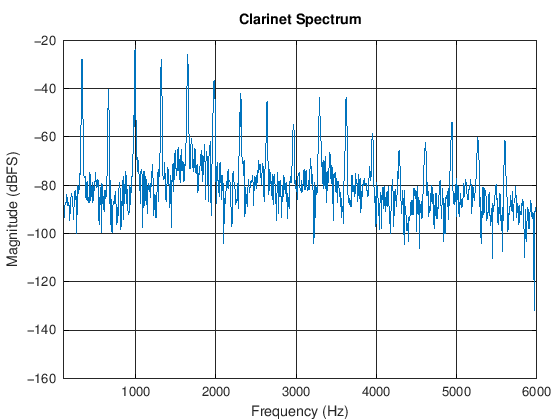

In [8]:
plot_spectrum(y, fs, window_size, strcat(inst_title, ' Spectrum'));

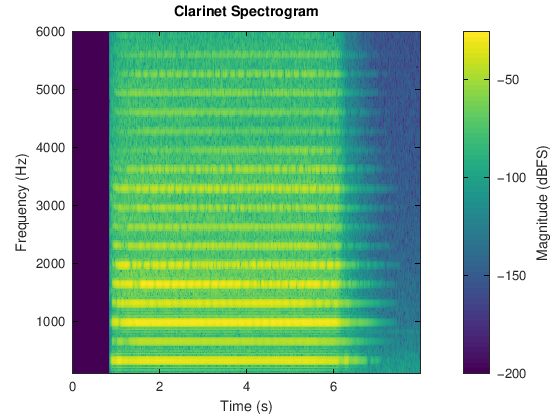

In [9]:
plot_spectrogram(y, fs, strcat(inst_title, ' Spectrogram'));

Next, let's save our data to a .mat file. We'll be converting this to SDIF, so we need to prepare it with metadata, too.:

In [10]:
meta.instrument_id = 2;    % 2 = clarinet (see instrument codes below)

output_file = sprintf('output/%s_%s_static.mat', inst_lower, meta.midi_note);
save_static_spectrum(output_file, freqs, amps, meta);

Saved static spectrum: output/clarinet_E4_static.mat (20 partials)


Now we're going to do some time-varying analysis.

In [11]:
printf('Analyzing %s evolution...\n\n', inst_lower);

window_size = 4096; % we're using a different window size for time-varying analysis
hop_size = 2048;    % samples between frames
min_amplitude = -60;
[times, freqs_matrix, amps_matrix, meta] = analyze_spectral_evolution(
  input_file, window_size, hop_size, min_amplitude);

Analyzing clarinet evolution...

  Frame 10/186 (t=0.38s)
  Frame 20/186 (t=0.81s)
  Frame 30/186 (t=1.24s)
  Frame 40/186 (t=1.66s)
  Frame 50/186 (t=2.09s)
  Frame 60/186 (t=2.52s)
  Frame 70/186 (t=2.94s)
  Frame 80/186 (t=3.37s)
  Frame 90/186 (t=3.80s)
  Frame 100/186 (t=4.22s)
  Frame 110/186 (t=4.65s)
  Frame 120/186 (t=5.08s)
  Frame 130/186 (t=5.50s)
  Frame 140/186 (t=5.93s)
  Frame 150/186 (t=6.36s)
  Frame 160/186 (t=6.78s)
  Frame 170/186 (t=7.21s)
  Frame 180/186 (t=7.64s)


Partial trajectory plots - show how individual partials evolve over time. Let's look at frequency trajectory first:

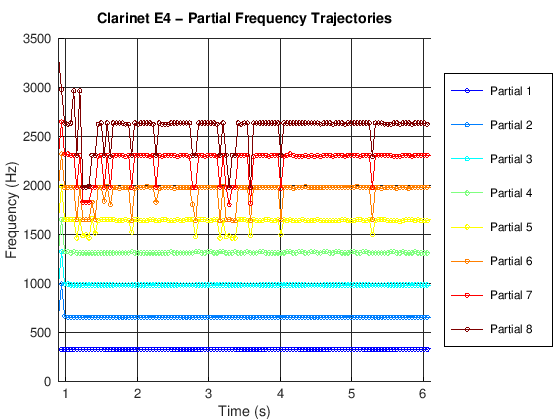

In [12]:
t_range = [0.9,6.1];
title_prefix = sprintf("%s %s", inst_title, meta.midi_note);
plot_partial_freq_trajectories(times, freqs_matrix, 8, title_prefix, t_range);

Now amplitude:

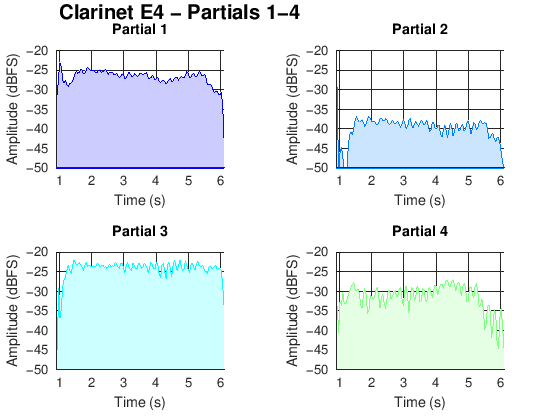

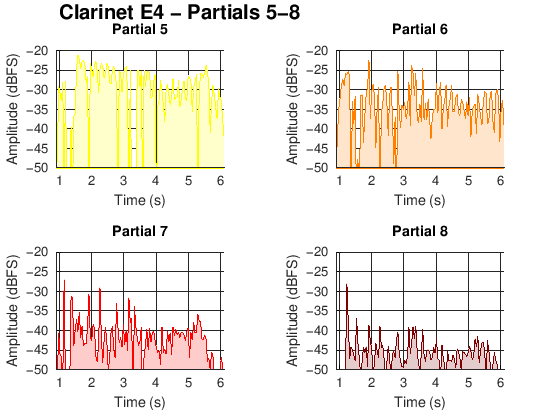

In [13]:
db_range = [-50,-20];
margins = [0.1, 0.1, 0.12, 0.12];
gaps = [0.2, 0.2];
plot_partial_amp_trajectories(times, amps_matrix, 8, title_prefix, t_range, db_range, margins, gaps);

Harmonic ratio evolution - shows how the harmonic series deviates from perfect integers over time (inharmonicity):

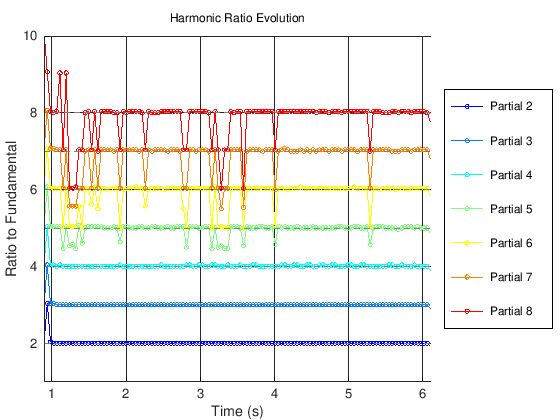

In [14]:
% Plot individual partial trajectories
p_range = [1,10];
plot_harmonic_ratios(times, freqs_matrix, 8, "", t_range, p_range);

Spectral centroid over time - Shows the "brightness" evolution, when the sound gets brighter (more high partials) or darker (more fundamental):

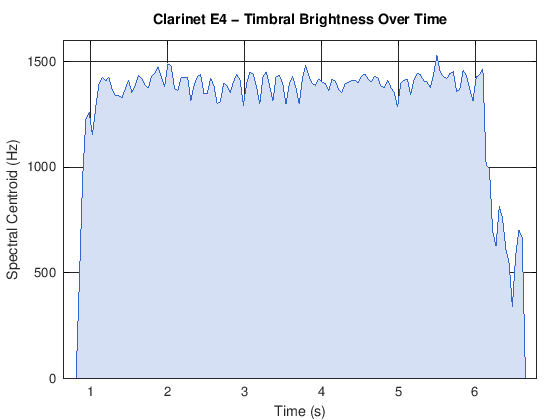

In [15]:
% Calculate spectral centroid for each frame
ct_range = [0.65, 6.8];
sc_range = [0, 1600];
plot_spectral_centroid(times, freqs_matrix, amps_matrix, title_prefix, ct_range, sc_range);

Number of active partials over time - shows when the timbre is richest:

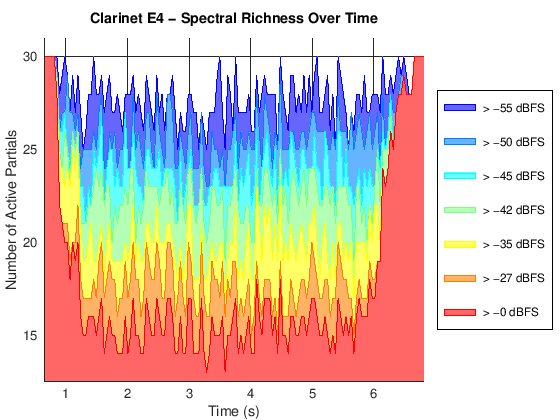

In [16]:
db_thresholds = [-0.5, -27, -35, -42, -45, -50, -55]; % hand-picked based upon what showed up in the graph below
ap_range = [12.5, 31];
plot_spectral_richness(times, amps_matrix, db_thresholds, title_prefix, ct_range, ap_range);

Finally, let's save this data to a .mat file as well:

In [17]:
output_file = sprintf('output/%s_%s_evolution.mat', inst_lower, meta.midi_note);
save_spectral_evolution(output_file, times, freqs_matrix, amps_matrix, meta);

Saved spectral evolution: output/clarinet_E4_evolution.mat (185 frames, 0.00-7.85 sec)


## Caveat Quid Sequitur

**This section is a work in progress!**

Before we dive into the next instrument, there is something interesting to explore: when looking at the amplitude trajectories of the partials, one can see that there are swells and/or spikes in implitude for each partial, and that each partial could therefore provide inspiration for interesting spectro-analytically derived rhythmical patterns.

I haven't finished all the math for this yet, but I do have some initial explorations based on iterative analysis of the first four partials. I will share those graphs below as images and update this notebook later with functions and plot settings used to generate the data and the visualisations.

The graphs below represent the stages of analysis I stepped through to intuitively extract rhytymic elements from the frequencies of the individual partials (for now, just the first four partials).

A review of the first four partials:

![Gnuplot - Partials 1-4](./images/clarinet-cleaned-partials.png)

Envelope dynamics analysis (partials data + first derivative/velocity calculations):

![Gnuplot - Envelope Dynamics Analysis](./images/envelope-dynamics-overview.png)

Dynamic energy analysis (partials data x first derivative):

![Gnuplot - Dynamic Energy Analysis](./images/dynamic-energy-analysis.png)

Composite (of all partials) dynamic energy analysis:

![Gnuplot - Composite Dynamic Energy Analysis](./images/composite-energy-comparison.png)

Compare data compression algorithms:

![Gnuplot - Data Compression Comparison](./images/compression-comparison.png)

Compare smoothing windows for logarithmic compression of data:

![Gnuplot - Log-Compressed Smoothing Comparison](./images/log-compressed-smoothing-comparison.png)

Find the "center of mass" of the areas under the curves (centroid analysis):

![Gnuplot - Centroid Analysis](./images/centroid-analysis.png)

![Gnuplot - Centroid Table](./images/centroid-table.png)

## End Caveat

#### Oboe

We will not go through all the visualisations that we did for the clarient with the oboe. Instead, we'll just do the basic ones and create a .mat file for conversion to .sdif.

The following oboe recording is of A4 with vibrato:

In [18]:
inst_lower = 'oboe';
inst_title = titlecase(inst_lower);
input_file = sprintf('audio/%s.wav', inst_lower);

[y, fs] = audioread(input_file);

% We only need one channel from a stereo wav file
if size(y, 2) > 1
    y = y(:, 1);
end

printf('Loaded: %d samples at %d Hz\n\n', length(y), fs);

% High-pass filter at 80 Hz to remove DC offset and rumble
[b, a] = butter(4, 80/(fs/2), 'high');
y = filter(b, a, y);

% Analyze
window_size = 8192;
[freqs, amps, meta] = analyze_static_spectrum(y, fs, window_size);
print_harmonics(freqs, amps);

% Save
printf('\n');
meta.instrument_id = 1;    % 1 = oboe (see instrument codes below)
output_file = sprintf('output/%s_%s_static.mat', inst_lower, meta.midi_note);
save_static_spectrum(output_file, freqs, amps, meta);

Loaded: 384000 samples at 48000 Hz

Frequency    Closest    MIDI       Partial       Amplitude    Velocity   Dynamic 
(Hz)         Note       Note       Ratio         (dBFS)       (MIDI)             
-------------------------------------------------------------------------------------
439.5        A4         69         1.00          -39.2        61         p       
884.8        A5         81         2.01          -32.8        73         mp      
1324.2       E6         88         3.01          -20.6        95         mf      
1757.8       A6         93         4.00          -39.3        61         p       
2197.3       C#7        97         5.00          -41.4        56         p       
2648.4       E7         100        6.03          -49.4        39         pp      
3076.2       G7         103        7.00          -44.7        49         pp      
3521.5       A7         105        8.01          -46.5        45         pp      
3955.1       B7         107        9.00          -48.1    

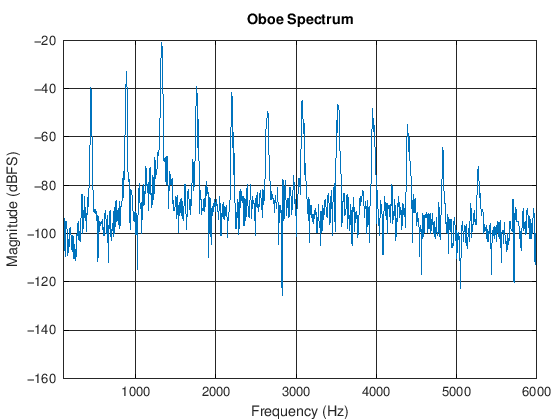

In [19]:
plot_spectrum(y, fs, window_size, sprintf('%s Spectrum', inst_title));

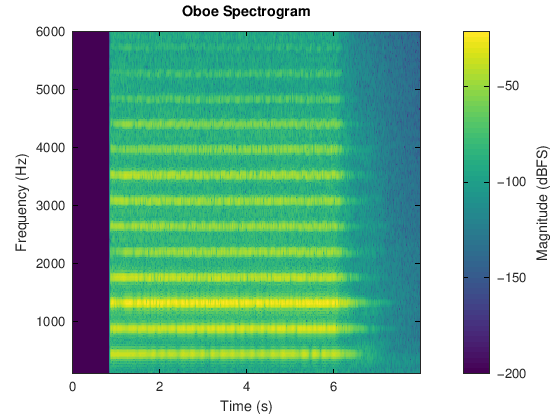

In [20]:
plot_spectrogram(y, fs, sprintf('%s Spectrogram', inst_title));

Now let's do the time-varying analysis and save that data (without any of the visualisation for it):

In [21]:
printf('Analyzing %s evolution...\n\n', inst_lower);

window_size = 4096; % we're using a different window size for time-varying analysis
hop_size = 2048;    % samples between frames
min_amplitude = -60;
[times, freqs_matrix, amps_matrix, meta] = analyze_spectral_evolution(
  input_file, window_size, hop_size, min_amplitude);
printf('\n');

output_file = sprintf('output/%s_%s_evolution.mat', inst_lower, meta.midi_note);
save_spectral_evolution(output_file, times, freqs_matrix, amps_matrix, meta);

Analyzing oboe evolution...

  Frame 10/186 (t=0.38s)
  Frame 20/186 (t=0.81s)
  Frame 30/186 (t=1.24s)
  Frame 40/186 (t=1.66s)
  Frame 50/186 (t=2.09s)
  Frame 60/186 (t=2.52s)
  Frame 70/186 (t=2.94s)
  Frame 80/186 (t=3.37s)
  Frame 90/186 (t=3.80s)
  Frame 100/186 (t=4.22s)
  Frame 110/186 (t=4.65s)
  Frame 120/186 (t=5.08s)
  Frame 130/186 (t=5.50s)
  Frame 140/186 (t=5.93s)
  Frame 150/186 (t=6.36s)
  Frame 160/186 (t=6.78s)
  Frame 170/186 (t=7.21s)
  Frame 180/186 (t=7.64s)

Saved spectral evolution: output/oboe_A4_evolution.mat (185 frames, 0.00-7.85 sec)


#### Horn

F4

In [22]:
inst_lower = 'horn';
inst_title = titlecase(inst_lower);
input_file = sprintf('audio/%s.wav', inst_lower);

[y, fs] = audioread(input_file);

% We only need one channel from a stereo wav file
if size(y, 2) > 1
    y = y(:, 1);
end

printf('Loaded: %d samples at %d Hz\n', length(y), fs);

Loaded: 384000 samples at 48000 Hz


In [23]:
% High-pass filter at 80 Hz to remove DC offset and rumble
[b, a] = butter(4, 80/(fs/2), 'high');
y = filter(b, a, y);

% Analyze
[freqs, amps, meta] = analyze_static_spectrum(y, fs, window_size);
print_harmonics(freqs, amps);

% Save
printf('\n');
meta.instrument_id = 9;    % 9 = horn (see instrument codes below)
output_file = sprintf('output/%s_%s_static.mat', inst_lower, meta.midi_note);
save_static_spectrum(output_file, freqs, amps, meta);

Frequency    Closest    MIDI       Partial       Amplitude    Velocity   Dynamic 
(Hz)         Note       Note       Ratio         (dBFS)       (MIDI)             
-------------------------------------------------------------------------------------
351.6        F4         65         1.00          -14.2        105        f       
503.9        B4         71         1.43          -53.5        28         ppp     
703.1        F5         77         2.00          -17.2        101        f       
925.8        A#5        82         2.63          -53.4        28         ppp     
1054.7       C6         84         3.00          -24.6        88         mf      
1406.2       F6         89         4.00          -35.8        68         mp      
1746.1       A6         93         4.97          -43.9        51         p       
2085.9       C7         96         5.93          -38.2        63         p       
2437.5       D#7        99         6.93          -40.1        59         p       
2789.1      

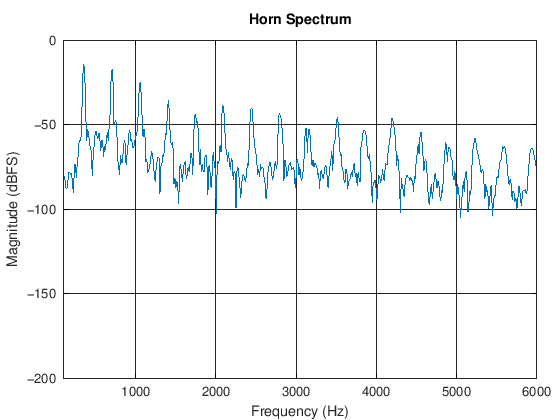

In [24]:
plot_spectrum(y, fs, window_size, sprintf('%s Spectrum', inst_title));

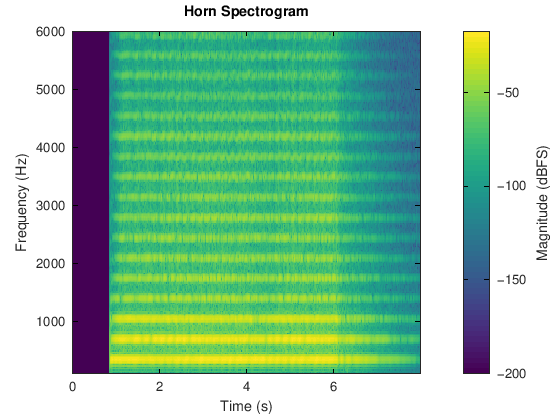

In [25]:
plot_spectrogram(y, fs, sprintf('%s Spectrogram', inst_title));

In [26]:
printf('Analyzing %s evolution...\n\n', inst_lower);

window_size = 4096; % we're using a different window size for time-varying analysis
hop_size = 2048;    % samples between frames
min_amplitude = -60;
[times, freqs_matrix, amps_matrix, meta] = analyze_spectral_evolution(
  input_file, window_size, hop_size, min_amplitude);
printf('\n');

output_file = sprintf('output/%s_%s_evolution.mat', inst_lower, meta.midi_note);
save_spectral_evolution(output_file, times, freqs_matrix, amps_matrix, meta);

Analyzing horn evolution...

  Frame 10/186 (t=0.38s)
  Frame 20/186 (t=0.81s)
  Frame 30/186 (t=1.24s)
  Frame 40/186 (t=1.66s)
  Frame 50/186 (t=2.09s)
  Frame 60/186 (t=2.52s)
  Frame 70/186 (t=2.94s)
  Frame 80/186 (t=3.37s)
  Frame 90/186 (t=3.80s)
  Frame 100/186 (t=4.22s)
  Frame 110/186 (t=4.65s)
  Frame 120/186 (t=5.08s)
  Frame 130/186 (t=5.50s)
  Frame 140/186 (t=5.93s)
  Frame 150/186 (t=6.36s)
  Frame 160/186 (t=6.78s)
  Frame 170/186 (t=7.21s)
  Frame 180/186 (t=7.64s)

Saved spectral evolution: output/horn_F4_evolution.mat (185 frames, 0.00-7.85 sec)


#### Tuba

A3

In [27]:
inst_lower = 'tuba';
inst_title = titlecase(inst_lower);
input_file = sprintf('audio/%s.wav', inst_lower);

[y, fs] = audioread(input_file);

% We only need one channel from a stereo wav file
if size(y, 2) > 1
    y = y(:, 1);
end

printf('Loaded: %d samples at %d Hz\n', length(y), fs);

Loaded: 384000 samples at 48000 Hz


In [28]:
% High-pass filter at 20 Hz to remove DC offset and rumble
[b, a] = butter(4, 20/(fs/2), 'high');
y = filter(b, a, y);

% Analyze
[freqs, amps, meta] = analyze_static_spectrum(y, fs, window_size);
print_harmonics(freqs, amps);

% Save
printf('\n');
meta.instrument_id = 10;    % 10 = tuba (see instrument codes below)
output_file = sprintf('output/%s_%s_static.mat', inst_lower, meta.midi_note);
save_static_spectrum(output_file, freqs, amps, meta);

Frequency    Closest    MIDI       Partial       Amplitude    Velocity   Dynamic 
(Hz)         Note       Note       Ratio         (dBFS)       (MIDI)             
-------------------------------------------------------------------------------------
222.7        A3         57         1.00          -20.6        95         mf      
445.3        A4         69         2.00          -21.5        93         mf      
656.2        E5         76         2.95          -27.2        84         mf      
878.9        A5         81         3.95          -41.9        55         p       
1101.6       C#6        85         4.95          -50.8        35         pp      
1324.2       E6         88         5.95          -44.6        50         p       

Saved static spectrum: output/tuba_A3_static.mat (6 partials)


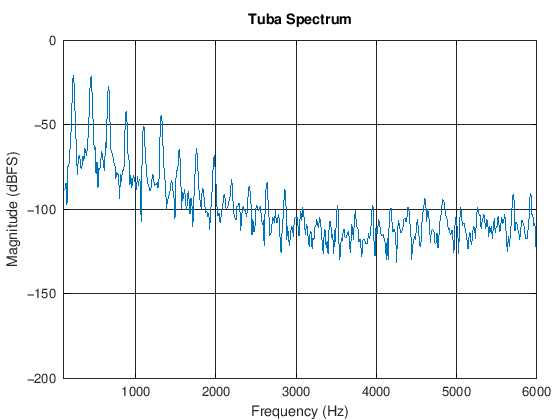

In [29]:
plot_spectrum(y, fs, window_size, sprintf('%s Spectrum', inst_title));

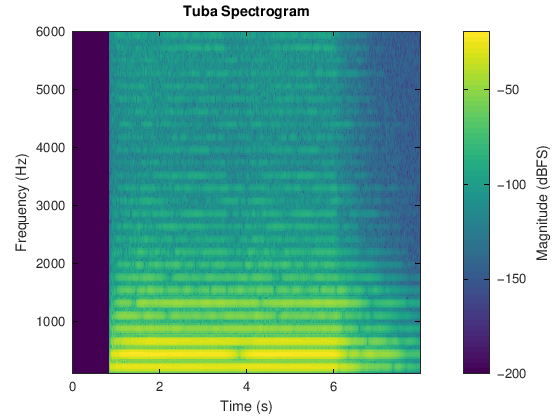

In [30]:
plot_spectrogram(y, fs, sprintf('%s Spectrogram', inst_title));

In [31]:
printf('Analyzing %s evolution...\n\n', inst_lower);

window_size = 4096; % we're using a different window size for time-varying analysis
hop_size = 2048;    % samples between frames
min_amplitude = -60;
[times, freqs_matrix, amps_matrix, meta] = analyze_spectral_evolution(
  input_file, window_size, hop_size, min_amplitude);
printf('\n');

output_file = sprintf('output/%s_%s_evolution.mat', inst_lower, meta.midi_note);
save_spectral_evolution(output_file, times, freqs_matrix, amps_matrix, meta);

Analyzing tuba evolution...

  Frame 10/186 (t=0.38s)
  Frame 20/186 (t=0.81s)
  Frame 30/186 (t=1.24s)
  Frame 40/186 (t=1.66s)
  Frame 50/186 (t=2.09s)
  Frame 60/186 (t=2.52s)
  Frame 70/186 (t=2.94s)
  Frame 80/186 (t=3.37s)
  Frame 90/186 (t=3.80s)
  Frame 100/186 (t=4.22s)
  Frame 110/186 (t=4.65s)
  Frame 120/186 (t=5.08s)
  Frame 130/186 (t=5.50s)
  Frame 140/186 (t=5.93s)
  Frame 150/186 (t=6.36s)
  Frame 160/186 (t=6.78s)
  Frame 170/186 (t=7.21s)
  Frame 180/186 (t=7.64s)

Saved spectral evolution: output/tuba_A3_evolution.mat (185 frames, 0.00-7.85 sec)


## Spectralism: Composing in the Spirit of Gérard Grisey

For the source material, I will be using two voices (alto and soprano) from Giovanni Pierluigi da Palestrina's *Missa Papae Marcelli*, in particular a portion of the "Kyrie":

![Score excerpt](./images/palestrina-mpm-kyrie-excerpt.jpg)

I will be recording the sounds of several instruments playing various notes from this harmonic/melodic (voice-leading) content and performing spectral analysis on the partials for said instruments, and then using notes cloest to observed partials to reimagine the harmony and voice-leading.

Taking inspiration from the piece "Partiels" I am going to start the composition with a descent (instead of ascent) down the overtones until we get to the source A and E notes. I will be using the frequencies listed above, filtering out the ones that are possibly noise (non-fundamentals) and subsituting rests for fundamentals that are below a certain threshold. This will give me the following:

Clarinet:

```
Frequency    Closest    MIDI       Partial       Amplitude    Velocity   Dynamic 
(Hz)         Note       Note       Ratio         (dBFS)       (MIDI)             
-------------------------------------------------------------------------------------
328.1        E4         64         1.00          -27.6        83         mf      
656.2        E5         76         2.00          -40.2        59         p       
990.2        B5         83         3.02          -23.7        90         mf      
1318.4       E6         88         4.02          -27.8        83         mf      
1646.5       G#6        92         5.02          -25.8        86         mf      
1980.5       B6         95         6.04          -36.4        67         mp      
2308.6       D7         98         7.04          -42.0        55         p       
2636.7       E7         100        8.04          -45.3        48         pp      
2970.7       F#7        102        9.05          -54.9        23         ppp     
3293.0       G#7        104        10.04         -43.5        52         p       
3627.0       A#7        106        11.05         -43.5        52         p       
3949.2       B7         107        12.04         -58.3        12         pppp    
4289.1       <rest>     108        13.07         -65.6        1          pppp    
4611.3       <rest>     110        14.05         -62.1        1          pppp    
4945.3       D#8        111        15.07         -53.9        26         ppp     
5267.6       <rest>     112        16.05         -60.3        1          pppp    
5601.6       <rest>     113        17.07         -61.4        1          pppp     
```

![Max screenshot of clarinet partials](./images/clarinet-max-sdif.jpg)

Oboe:

```
Frequency    Closest    MIDI       Partial       Amplitude    Velocity   Dynamic 
(Hz)         Note       Note       Ratio         (dBFS)       (MIDI)             
-------------------------------------------------------------------------------------
439.5        A4         69         1.00          -39.2        61         p       
884.8        A5         81         2.01          -32.8        73         mp      
1324.2       E6         88         3.01          -20.6        95         mf      
1757.8       A6         93         4.00          -39.3        61         p       
2197.3       C#7        97         5.00          -41.4        56         p       
2648.4       E7         100        6.03          -49.4        39         pp      
3076.2       G7         103        7.00          -44.7        49         pp      
3521.5       A7         105        8.01          -46.5        45         pp      
3955.1       B7         107        9.00          -48.1        42         pp      
4388.7       C#8        109        9.99          -54.8        24         ppp   
```

![Max screenshot of oboe partials](./images/oboe-max-sdif.jpg)

For the next phase, I will be using the recording of at tuba at note A3:

```
Frequency    Closest    MIDI       Partial       Amplitude    Velocity   Dynamic 
(Hz)         Note       Note       Ratio         (dBFS)       (MIDI)             
-------------------------------------------------------------------------------------
222.7        A3         57         1.00          -20.6        95         mf      
445.3        A4         69         2.00          -21.5        93         mf      
656.2        E5         76         2.95          -27.2        84         mf      
878.9        A5         81         3.95          -41.9        55         p       
1101.6       C#6        85         4.95          -50.8        35         pp      
1324.2       E6         88         5.95          -44.6        50         p    
```

![Max screenshot of tuba partials](./images/tuba-max-sdif.jpg)

For the section after that, I will be using the recording of a horn at note F4:

```
Frequency    Closest    MIDI       Partial       Amplitude    Velocity   Dynamic 
(Hz)         Note       Note       Ratio         (dBFS)       (MIDI)             
-------------------------------------------------------------------------------------
351.6        F4         65         1.00          -14.2        105        f       
503.9        B4         71         1.43          -53.5        28         ppp     
703.1        F5         77         2.00          -17.2        101        f       
925.8        A#5        82         2.63          -53.4        28         ppp     
1054.7       C6         84         3.00          -24.6        88         mf      
1406.2       F6         89         4.00          -35.8        68         mp      
1746.1       A6         93         4.97          -43.9        51         p       
2085.9       C7         96         5.93          -38.2        63         p       
2437.5       D#7        99         6.93          -40.1        59         p       
2789.1       F7         101        7.93          -42.8        53         p       
3128.9       G7         103        8.90          -52.1        31         ppp     
3515.6       A7         105        10.00         -45.5        48         pp      
3843.8       B7         107        10.93         -53.0        29         ppp     
4195.3       C8         108        11.93         -45.9        47         pp      
4558.6       C#8        109        12.97         -54.2        25         ppp  
```

![Max screenshot of horn partials](./images/horn-max-sdif.jpg)

## Appendices

### MAT File Metadata

The tool we're using to convert .mat files to .sdif files currently only supports integers and arrays of integers. As such, we've had to encode non-integer metadata as integers. Here's the instrument lookup we've defined for this work:

```
% Instrument codes (for metadata.instrument_id):
% 0 = unspecified/unknown
% 1 = oboe
% 2 = clarinet
% 3 = flute
% 4 = piccolo
% 5 = violin
% 6 = viola
% 7 = cello
% 8 = synthesizer
% 9 = horn
% 10 = tuba
```

### Helper Functions

Here are the custom functions mentioned and included above that were created specifically for this project:

In [32]:
!cat packages/custom-util/fs.m

function ensure_dirs(filepath)
  % Extract directory from filepath
  [dir, name, ext] = fileparts(filepath);

  % Create directory if it doesn't exist
  if !exist(dir, 'dir')
    mkdir(dir)
  endif
endfunction

printf('File system functions loaded!\n');



In [33]:
!cat packages/custom-util/strings.m

function result = titlecase(str)
  % Convert to lowercase first
  str = lower(str);

  % Make the first character uppercase
  if length(str) > 0
    str(1) = upper(str(1));
  endif

  % Find spaces and capitalize the letter after each space
  spaces = find(str == ' ');
  for i = 1:length(spaces)
    if spaces(i) < length(str)
      str(spaces(i) + 1) = upper(str(spaces(i) + 1));
    endif
  endfor

  result = str;
endfunction

printf('String functions loaded!\n');



In [34]:
!cat packages/custom-dsp/freq-analysis.m

% Find harmonics from a spectrum
function [freqs, amps, metadata] = analyze_static_spectrum(signal, fs, window_size)
    % Analyze a single spectral snapshot
    %
    % Args:
    %   signal: audio signal (mono)
    %   fs: sample rate in Hz
    %   window_size: FFT window size (default 4096)
    %
    % Returns:
    %   freqs: array of peak frequencies in Hz
    %   amps: array of peak amplitudes in dBFS
    %   metadata: struct with analysis parameters

    if nargin < 3
        window_size = 4096;
    end

    % Take a chunk from the middle of the file (avoid silence at start/end)
    mid_point = floor(length(signal) / 2);
    start_idx = mid_point - floor(window_size / 2);
    if start_idx < 1
        start_idx = 1;
    end
    chunk_size = min(window_size, length(signal) - start_idx + 1);
    chunk = signal(start_idx:start_idx + chunk_size - 1) .* hanning(chunk_size);

    % Zero-pad for better frequency resolution
    padded = [chunk; zeros(window_size - chunk_size, 1)];

    % C

In [35]:
!cat packages/custom-dsp/time-varying-analysis.m

% time-varying-analysis.m
% Functions for time-varying spectral analysis

function [times, freqs_matrix, amps_matrix, metadata] = analyze_spectral_evolution(audio_file, window_size, hop_size, min_amplitude)
    % Analyze time-varying spectrum across an audio file
    %
    % Parameters:
    %   audio_file - path to .wav file (string)
    %   window_size - FFT window size (optional, default 4096)
    %   hop_size - samples between frames (optional, default window_size/2)
    %   min_amplitude - minimum dBFS to include partial (optional, default 15)
    %
    % Returns:
    %   times - 1D array of time points in seconds (row vector)
    %   freqs_matrix - 2D array [num_frames × max_partials], zero-padded
    %   amps_matrix - 2D array [num_frames × max_partials], zero-padded
    %   metadata - struct with fields:
    %     .num_frames - actual number of frames analyzed
    %     .num_partials_per_frame - 1D array of partial counts per frame
    %     .sample_rate - sample rate in Hz
    

In [36]:
!cat packages/custom-dsp/rhythmic-analysis.m

% ============================================================================
% RHYTHMIC ANALYSIS FUNCTIONS FOR AMPLITUDE ENVELOPES
% ============================================================================

function smoothed = smooth_envelope(envelope, window_size)
    % Smooth amplitude envelope using moving average
    %
    % Args:
    %   envelope: amplitude values
    %   window_size: number of samples to average
    %
    % Returns:
    %   smoothed: smoothed envelope

    if nargin < 2
        window_size = 5;
    end

    % Ensure envelope is a column vector
    envelope = envelope(:);

    % Ensure we have enough data
    if length(envelope) < window_size
        smoothed = envelope;
        return;
    end

    % Simple moving average using convolution
    kernel = ones(window_size, 1) / window_size;  % Make kernel same orientation
    smoothed = conv(envelope, kernel, 'same');
end


function [peak_times, peak_values] = find_amplitude_peaks(times, amps, min_peak_height,

In [37]:
!cat packages/custom-dsp/spectral-io.m

% spectral-io.m
% Functions for saving and loading spectral analysis data in .mat format

function save_static_spectrum(filename, freqs, amps, metadata)
    % Save a single spectral snapshot to .mat file
    %
    % Parameters:
    %   filename - output .mat file path (string)
    %   freqs - 1D array of frequencies in Hz
    %   amps - 1D array of amplitudes in dBFS
    %   metadata - struct with fields:
    %     .fundamental (required, scalar) - fundamental frequency in Hz
    %     .sample_rate (required, scalar) - sample rate in Hz
    %     .instrument_id (optional, scalar, default 0) - numeric instrument code
    %     .midi_note (optional, scalar, default 0) - MIDI note number (0-127)
    %     .time_stamp (optional, scalar, default 0.0) - time in seconds

    % Reshape to row vectors
    freqs = reshape(freqs, 1, []);
    amps = reshape(amps, 1, []);

    % Calculate number of partials
    num_partials = length(freqs);

    % Extract required metadata
    fundamental = metadat

In [38]:
!cat packages/custom-dsp/rhythmic-io.m

% ============================================================================
% RHYTHMIC ANALYSIS EXPORT FUNCTIONS
% ============================================================================

function export_rhythmic_analysis_text(analyses, filename, title_str)
    % Export rhythmic analysis to human-readable text file
    %
    % Args:
    %   analyses: cell array of analysis structs
    %   filename: output text file path
    %   title_str: optional title for the report

    if nargin < 3
        title_str = 'Rhythmic Analysis Report';
    end

    fid = fopen(filename, 'w');
    if fid == -1
        error('Could not open file for writing: %s', filename);
    end

    % Write header
    fprintf(fid, '================================================================================\n');
    fprintf(fid, '%s\n', title_str);
    fprintf(fid, 'Generated: %s\n', datestr(now));
    fprintf(fid, '================================================================================\n\n');

   